<center> <b> <font size="3"> <font color="green">rfborg </font> :
    your detector technology will be assimilated— resistance is futile! </font> </b> </center> 

In [1]:
import os
import casperfpga
import struct
from time import sleep
from matplotlib import pyplot as plt
import numpy as np
import ipywidgets as ipw
from ipywidgets import interact, interactive, fixed, interact_manual
from scipy import signal
#import valon_synth9 as Valon

ModuleNotFoundError: No module named 'casperfpga'

In [ ]:
FPG = "blast_module_v5_2022-04-27_1053.fpg"
ZCU111_HOST = "192.168.2.99"
LMKFILE = "122M88_PL_122M88_SYSREF_7M68_clk5_12M8.txt"
LMXFILE = "LMX_REF_122M88_OUT_245M76.txt"
ADC_SAMPLE_RATE_MHZ = 3932.16
ADC_DECIMATION = 8

In [2]:
# FIRMWARE UPLOAD
fpga = casperfpga.CasperFpga(ZCU111_HOST)
fpga.upload_to_ram_and_program(FPG)
rfdc = fpga.adcs['rfdc']
rfdc.init(lmk_file=LMKFILE, lmx_file=LMXFILE)

# Generating DDS/DAC Waveform

In [5]:
# class rfsocInterface:
#     """
#     Set of functions running on the RFSoC to generate/capture/demodulate waveforms by interfacing with 
#     AXI registers and Block-Memory (BRAM) programmed in the firmware. 
#     """
ADDR_SIZE = 17
def norm_wave(ts, max_amp=2**15-1):
    """
     Re-scale generated data values to fit LUT
    """
    norm = max(abs(ts)) # abs to get magnitude of complex vector
    dacI = ((ts.real/norm)*max_amp).astype("int16")
    dacQ = ((ts.imag/norm)*max_amp).astype("int16")
    return dacI, dacQ

def surfsUpDude(freq_list, vna = False, verbose=False):
    """
    surfsUpDude Takes a list of specified frequencies and generates....stuff and things, then 
    uploads to the bram. Then we'll have totally ripped waves bruh, schralping the gnar.
    
    params
        freqlist: np.array
            list of tones to generate
        verbose: bool
            enable / disable printing (and or) plotting of data
    """
    #####################################################
    # HARDCODED LUT PARAMS
    #####################################################
    addr_size=ADDR_SIZE   # address bit width
    channels= 2           # data points per memory address for DAC
    fs = ADC_SAMPLE_RATE_MHZ * 1e6   # sampling rate of D/A, FPGA fabric = fs/2
    C  = ADC_DECIMATION              # decimation factor
    data_p = channels*2**(addr_size) # length of timestream or length of LUT+1
    
    #####################################################
    #  SET FREQ for LUT
    #####################################################
    if vna:
      N = 1000 # number of tones to make
      freqs = -1*C*np.linspace(-250.0e6, 250.0e6,N) # equally spaced tones
    else:
      freqs = -1*C*freq_list # equally spaced tones
    #phases = np.random.uniform(-np.pi,np.pi,len(freqs))
    np.random.seed(0)
    phases = np.random.uniform(0,np.pi,len(freqs))
    #print(phases)

    ######################################################
    # DAC Params
    ######################################################
    A = 2**15-1 # 16 bit D/A, expecting signed values.
    freq_res = fs/data_p # Hz
    fftbin_bw = 5e5 # Hz for effective bandwidth of 512MHz/1024 point fft
    ######################################################
    # GENERATE LUT WAVEFORM FROM FREQ LIST
    ######################################################
    freqs = np.round(freqs/(freq_res))*freq_res
    
    #print(-1*freqs*0.5e-6)
    delta = np.zeros(data_p,dtype="complex") # empty array of deltas
    for i in range(len(freqs)):
        bin_num = np.round((freqs[i]/freq_res)).astype('int')
        delta[bin_num] = (1)*np.exp(1j*phases[i])   
    ts = np.fft.ifft(delta)
    


    # GENERATE DDC WAVEFORM FROM BEAT FREQS
    f_beat = (freqs/2)%(fftbin_bw)
    
    print("{} Frequencies Generated:".format(len(freqs)))
    if verbose:
        print("\n{0:7} {1:7} {2:7}".format("freq","phase","beat" ))
        for ind in range(len(freqs)):
            print("{0:7.3f} {1:7.3f} {2:7.3f}".format(freqs[ind]*-0.5e-6,phases[ind],f_beat[ind]*1e-6))
        print("-"*25)

    ###########
    # new DDC
    ###########
    wave_ddc = np.zeros( int(data_p), dtype="complex") # empty array of deltas
    delta_ddc = np.zeros( shape=(len(freqs),2**9), dtype="complex") # empty array of deltas
    beat_ddc = np.zeros(shape=(len(freqs),2**9), dtype="complex")
    bin_num_ddc = np.round(f_beat*2/freq_res)

    for i in range(len(freqs)): 
        delta_ddc[i,int(bin_num_ddc[i])] = (1)*np.exp(-1j*phases[i])
        beat_ddc[i] = np.fft.ifft(delta_ddc[i])

    for i in range(1024):
        if (i<len(freqs)):
            wave_ddc[i::1024] = beat_ddc[i]
        else:
            wave_ddc[i::1024] = 0.0001*(1+1j)/np.sqrt(2) #sets ones for arrays


    dacI, dacQ = norm_wave(ts)
    ddcI, ddcQ = norm_wave(wave_ddc, max_amp=(2**15)-1)
    
    ### 
    # DDC DEBUGGING
    # ddcI, ddcQ = ((1<<15)-1)*np.ones(int(data_p)), ((1<<15)-1)*np.ones(int(data_p)) # 16.15
    ###
    
    return dacI, dacQ, ddcI, ddcQ, freqs
    
    ##############################
    # DDC Values
    ##############################
    ddcQ_val = ((np.int32(ddcQ[1::2]) << 16) + ddcQ[0::2]).astype("int32")
    ddcI_val = ((np.int32(ddcI[1::2]) << 16) + ddcI[0::2]).astype("int32")

    dacQ_val = ((np.int32(dacQ[1::2]) << 16) + dacQ[0::2]).astype("int32")
    dacI_val = ((np.int32(dacI[1::2]) << 16) + dacI[0::2]).astype("int32")

    LUT_I, LUT_Q = np.zeros(data_p//2).astype("int32"), np.zeros(data_p).astype("int32")
    DDS_I, DDS_Q = np.zeros(data_p//2).astype("int32"), np.zeros(data_p).astype("int32")

    LUT_I = dacI_val
    LUT_Q = dacQ_val
    DDS_I = ddcI_val
    DDS_Q = ddcQ_val
    return LUT_I, LUT_Q, DDS_I, DDS_Q, freqs

def load_dds(I, Q):
    I = np.array(I, dtype='>h')
    Q = np.array(Q, dtype='>h')
    fpga.write('dds_wave_i', I)
    fpga.write('dds_wave_q', Q)

def load_dac(I, Q):
    I = np.array(I, dtype='>h')
    Q = np.array(Q, dtype='>h')
    fpga.write('dac_wave_i', I)
    fpga.write('dac_wave_q', Q)

def load_bin_list(freqs):
    bin_list=-1*(np.round(freqs* 512/512e6))

    # initialization 
    if len(freqs)>400:
        fft_shift = ((2**5)-1)
    else:
        fft_shift = ((2**9)-1) #2**9
        
    fpga.write_int('fft_shift', fft_shift)
    
    accum_length = (2**(9+10))-1 # 2^10 avg length (+ 2^9 for delay)
    fpga.write_int('accum_len', accum_length)
    
    ################################################
    # Load DDC bins
    ################################################
    offs=16 # magickb
    fpga.write_int('load_bins', 0)
    for addr in range(1024): # POSSIBLY LOADING INCORRECT BINS
         if ((offs-1)<addr<(offs)+len(bin_list)):
             print("addr = {}, bin# = {}".format(addr, bin_list[addr-offs]))
             fpga.write_int('bins', bin_list[addr-offs])
             fpga.write_int('load_bins', 1)
             fpga.write_int('load_bins', 0)
         else:
             fpga.write_int('bins', 0)
             fpga.write_int('load_bins', 1)
             fpga.write_int('load_bins', 0)
    ##################################################33
    return

def load_waveform_into_mem(LI, LQ, DI, DQ):
    #######################################################
    # Load configured LUT values into FPGA memory
    #######################################################
    dds_shift=firmware.gpio3.axi_gpio_0 # offset 0x00

    load_dac(LI, LQ)
    load_dds(DI, DQ)

    ########################
    # Arming DDC Waveform
    ########################
    # initialization 
    sync_in = 2**26
    accum_rst = 2**24  # (active low)
    accum_length = (2**19)-1
    accum_and_bin_idx = firmware.gpio2.axi_gpio_0 # 0x00 bins, 0x08 0-23 accum len, 24 accum rst, 25 sync in
    # sync pulse
    fpga.write_int('sync', 0)
    fpga.write_int('sync', 1)
    fpga.write_int('sync', 0)
    # Accumulator reset # ACTIVE LOW(?)
    fpga.write_int('accum_rst', 1)
    fpga.write_int('accum_rst', 0)
    fpga.write_int('accum_rst', 1)
    fpga.write_int('dds_shift', int(16/2)) # this should be half of offs #magicka
    return 0

def set_lo(F_LO=1000,LO_power=0.0):
    """    
    Set VALON LO Power/Freq.      
    LO_power : dBm
    F_LO     : MHz
    """    
    
    source_channel=2
    valon=Valon.Synthesizer('/dev/ttyUSB0')
    valon.set_rf_level(source_channel,LO_power)
    valon.set_frequency(source_channel,F_LO)
    
    return 0

def set_atten(atten=0,channel=3):
    """
    Set IF IN/OUT ATTEN. Values
    RF OUT - channel 1
    RF IN  - channel 2
    BOTH   - channel 3
    """
    import serial
    ard = serial.Serial('/dev/ttyACM0',115200)
    write_out = str(channel) + "\n" + str(atten) + "\n"
    ard.write(write_out.encode("ASCII"))
    ard.close()
    return 0

In [ ]:
# set_atten(6,3) # use this if IF + LO is being used

In [ ]:
# set_lo(1000)   # use this if IF + LO is being used

In [40]:
LUT_I, LUT_Q, DDS_I, DDS_Q, freqs = surfsUpDude(np.linspace(20e6,200e6,1000), vna=False,verbose=True)
# LUT_I, LUT_Q, DDS_I, DDS_Q, freqs = surfsUpDude(np.linspace(50e6,200e6,16)+(.100e6)*np.random.rand(16), vna=False,verbose=True)
# LUT_I, LUT_Q, DDS_I, DDS_Q, freqs = surfsUpDude(np.asarray([0.5*180.211e6]), vna=False,verbose=True)

load_bin_list(freqs)
load_waveform_into_mem(LUT_I, LUT_Q, DDS_I, DDS_Q)

1000 Frequencies Generated:

freq    phase   beat   
 20.000   1.724   0.000
 20.181   2.247   0.319
 20.360   1.894   0.140
 20.541   1.712   0.459
 20.721   1.331   0.279
 20.901   2.029   0.099
 21.081   1.375   0.419
 21.262   2.802   0.238
 21.441   3.027   0.059
 21.622   1.205   0.378
 21.802   2.487   0.198
 21.982   1.662   0.018
 22.162   1.785   0.338
 22.343   2.908   0.157
 22.522   0.223   0.478
 22.703   0.274   0.297
 22.883   0.064   0.117
 23.063   2.616   0.437
 23.243   2.445   0.257
 23.424   2.733   0.076
 23.604   3.074   0.396
 23.784   2.511   0.216
 23.964   1.450   0.036
 24.145   2.452   0.355
 24.324   0.372   0.176
 24.505   2.010   0.495
 24.685   0.450   0.315
 24.865   2.968   0.135
 25.045   1.639   0.455
 25.226   1.303   0.274
 25.405   0.831   0.095
 25.586   2.432   0.414
 25.766   1.433   0.234
 25.946   1.786   0.054
 26.126   0.059   0.374
 26.307   1.940   0.193
 26.486   1.923   0.014
 26.667   1.938   0.333
 26.847   2.965   0.153
 27.027   2

185.405   2.379   0.095
185.586   0.988   0.414
185.766   2.065   0.234
185.946   1.625   0.054
186.126   1.524   0.374
186.307   2.831   0.193
186.486   1.742   0.014
186.667   2.598   0.333
186.847   2.279   0.153
187.027   0.121   0.473
187.207   2.429   0.293
187.388   0.681   0.112
187.567   2.837   0.433
187.748   0.135   0.252
187.928   1.046   0.072
188.108   0.313   0.392
188.288   1.494   0.212
188.469   2.576   0.031
188.648   0.937   0.352
188.829   0.474   0.171
189.009   1.038   0.491
189.189   2.557   0.311
189.369   0.441   0.131
189.550   0.714   0.450
189.729   0.216   0.271
189.910   2.217   0.090
190.090   1.242   0.410
190.271   0.977   0.229
190.450   2.258   0.050
190.631   1.056   0.369
190.811   2.286   0.189
190.991   2.561   0.009
191.171   0.684   0.329
191.352   3.059   0.148
191.531   0.510   0.469
191.712   0.914   0.288
191.892   0.565   0.108
192.072   1.085   0.428
192.252   1.508   0.248
192.433   1.640   0.067
192.612   2.682   0.388
192.793   2.794 

addr = 932, bin# = 370.0
addr = 933, bin# = 370.0
addr = 934, bin# = 371.0
addr = 935, bin# = 371.0
addr = 936, bin# = 372.0
addr = 937, bin# = 372.0
addr = 938, bin# = 372.0
addr = 939, bin# = 373.0
addr = 940, bin# = 373.0
addr = 941, bin# = 373.0
addr = 942, bin# = 374.0
addr = 943, bin# = 374.0
addr = 944, bin# = 374.0
addr = 945, bin# = 375.0
addr = 946, bin# = 375.0
addr = 947, bin# = 375.0
addr = 948, bin# = 376.0
addr = 949, bin# = 376.0
addr = 950, bin# = 377.0
addr = 951, bin# = 377.0
addr = 952, bin# = 377.0
addr = 953, bin# = 378.0
addr = 954, bin# = 378.0
addr = 955, bin# = 378.0
addr = 956, bin# = 379.0
addr = 957, bin# = 379.0
addr = 958, bin# = 379.0
addr = 959, bin# = 380.0
addr = 960, bin# = 380.0
addr = 961, bin# = 381.0
addr = 962, bin# = 381.0
addr = 963, bin# = 381.0
addr = 964, bin# = 382.0
addr = 965, bin# = 382.0
addr = 966, bin# = 382.0
addr = 967, bin# = 383.0
addr = 968, bin# = 383.0
addr = 969, bin# = 383.0
addr = 970, bin# = 384.0
addr = 971, bin# = 384.0


0

# ADC DATA

In [12]:
def get_snap_data():
  d, t = fpga.snapshots.adc_snapshot.read_raw(man_trig=True)
  v = struct.unpack('>%dh' % (d['length']//2), d['data'])
  vi = v[0::2]
  vq = v[1::2]
  return vi, vq

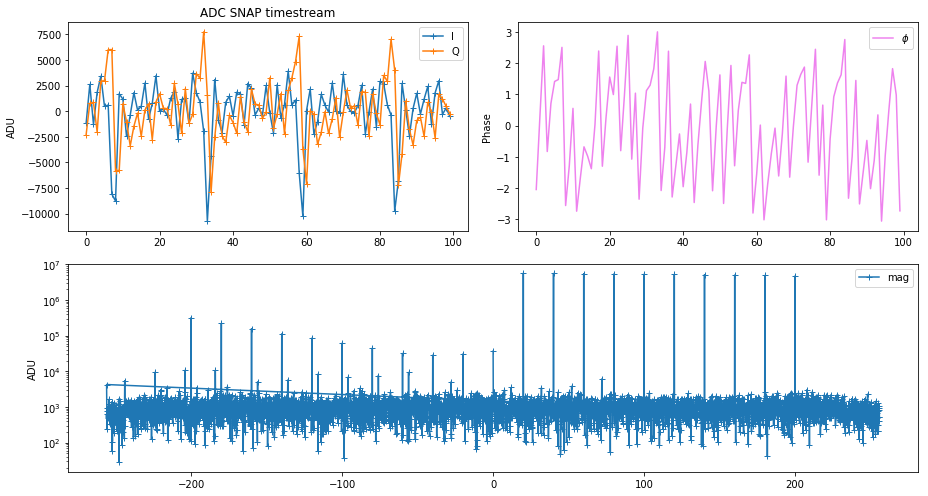

In [13]:
I3, Q3 = get_snap_data()

plt.figure(figsize=(13,7))
c = slice(0,100)

plt.subplot(221)
plt.plot(I3[c],"-+",label="I")
plt.plot(Q3[c],"-+",label="Q")
plt.title("ADC SNAP timestream")
plt.ylabel("ADU")
plt.legend()

plt.subplot(222)
plt.plot(np.arctan2(Q3[c],I3[c]),color="violet",label=r'$\phi$')
plt.ylabel("Phase")
plt.legend()

plt.subplot(2,2,(3,4))
spec=np.fft.fft(I3+1j*Q3)
spec_freqs = np.fft.fftfreq(len(I3),1/512)
spec=np.abs(spec) # |spec|
plt.semilogy(spec_freqs,spec,"-+",label="mag")
plt.ylabel("ADU")
plt.legend()
plt.tight_layout()
# plt.savefig("ADCsnap.pdf")
plt.show()

## Polyphase Filterbank Snap

In [14]:
# make sure to toggle sync (gpio) first
def get_pfb_data():
    d, t = fpga.snapshots.pfb.snapshot.read_raw()
    v = struct.unpack('>%dh' % (d['length']//2), d['data'])
    # Build complex values
    cv = np.zeros(len(v)//2, dtype=complex)
    cv.real = v[0::2]
    cv.imag = v[1::2]
    return cv

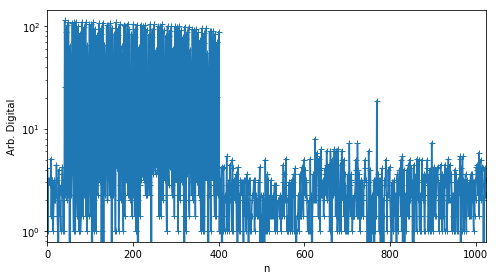

In [39]:
SPECpfb = get_pfb_data()
mag = abs(SPECpfb)

plt.figure(figsize=(7,4))
#plt.title(r"$f_s=2048MHZ, N_{bins}=512$"+"(7 tones, external hardware loopback)")
plt.xlabel("n"); plt.ylabel("Arb. Digital")
#plt.plot(mag)
plt.semilogy(mag,"-+",label='PFB mag')
plt.xlim(0,1024)
#plt.plot(Qpfb_f,"-+",label='Q')
#plt.legend()
plt.tight_layout()
#plt.savefig("pfb_snap.pdf")
plt.show()

In [ ]:
SPECpfb

In [ ]:
plt.figure(figsize=(8,5))
M=30
k= 108
#k+=512
chnl_ts = np.zeros(M,dtype=complex)
plt.title(f"{M} FPGA-PFB Capture(s)")
for i in range(M):
    SPECpfb = get_pfb_data()
    chnl_ts[i] = SPECpfb[k]
    mag = abs(SPECpfb)
    #print(mag[k])
    #plt.title(r"$f_s=2048MHZ, N_{bins}=512$"+"(7 tones, external hardware loopback)")
    plt.xlabel("n"); plt.ylabel("Arb. Digital")
    #plt.plot(mag)
    plt.plot(mag[1024*0:1*1024],".",color="black",alpha=0.5)
    plt.plot(mag[1024*1:2*1024],".",color="black",alpha=0.5)
    plt.plot(mag[1024*2:3*1024],".",color="black",alpha=0.5)
    plt.plot(mag[1024*3:4*1024],".",color="black",alpha=0.5)
    #plt.xlim(0,1024)
    plt.grid()
    plt.tight_layout()
#plt.axvline(1024+k,color="red",alpha=0.2)
plt.show()

plt.figure(figsize=(8,5));plt.title(f"Channel : {k},{(2*k)}MHz")
plt.plot(chnl_ts.real,"-+")
plt.plot(chnl_ts.imag,"-+")
plt.xlabel("FPGA-FFT CAPTURE")
plt.show()

# Digital Down Conversion

In [24]:
def get_ddc_data():
    d, _ = fpga.snapshots.ddc_snapshot.read_raw()
    v = struct.unpack('<%dh' % (ss0['length']//2), ss0['data'])
    # Build complex
    cv = np.zeros(len(v)//2, dtype=complex)
    cv.real = v[0::2]
    cv.imag = v[1::2]
    return cv

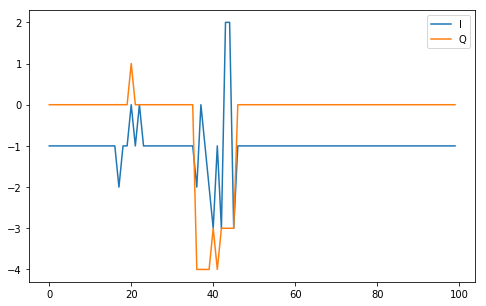

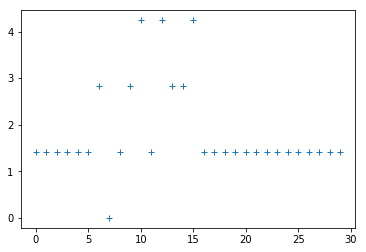

In [33]:
ddc_IQ_dat = get_ddc_data()

Iddc_f = ddc_IQ_dat.real[0:1024]
Qddc_f = ddc_IQ_dat.imag[0:1024]

plt.figure(figsize=(8,5))

plt.plot(Iddc_f[0:100],label='I')
plt.plot(Qddc_f[0:100],label='Q')
plt.legend()
plt.show()

plt.figure()
plt.plot(abs(Iddc_f+1j*Iddc_f)[30:60],"+")
plt.show()

In [ ]:
plt.figure(figsize=(1.25*8,1.25*5))

for n in range(50):
    sleep(0.005)
    ddc_IQ_dat = get_ddc_data()

    Iddc_f = ddc_IQ_dat.real[0:1024]
    Qddc_f = ddc_IQ_dat.imag[0:1024]

    plt.plot(abs(Iddc_f+1j*Iddc_f)[0:100],"+")
    #plt.xlim(210,230)
plt.grid()
plt.show()

## Vector Accumulate and Downsample

In [21]:
def get_accum_data():
    fpga.snapshots.acc_snapshot0.arm() # Arms 0 and 1
    ss0, _ = fpga.snapshots.acc_snapshot0.read_raw(arm=False)
    ss1, _ = fpga.snapshots.acc_snapshot1.read_raw(arm=False)
    v0 = struct.unpack('<%di' % (ss0['length']//4), ss0['data'])
    v1 = struct.unpack('<%di' % (ss1['length']//4), ss1['data'])
    # Build complex
    cv = np.zeros(len(v0), dtype=complex)
    cv.real = v0
    cv.imag = v1
    return cv

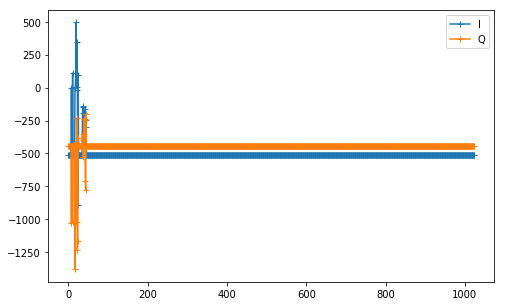

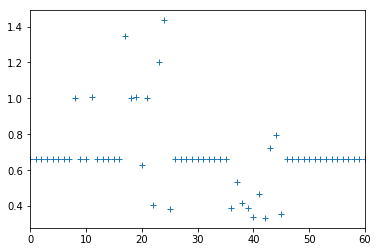

In [35]:
accum_IQ_dat = get_accum_data()
Iacc_f = accum_IQ_dat.real
Qacc_f = accum_IQ_dat.imag
Ia, Qa = np.array(Iacc_f), np.array(Qacc_f)

plt.figure(figsize=(8,5))
plt.plot(Ia[0*1024:1024],"-+",label='I')
plt.plot(Qa[0*1024:1024],"-+",label='Q')
plt.legend()
#plt.xlim(60-10,len(freqs)+60+10)
plt.show()

plt.figure()
IQMAG=np.sqrt(Ia**2+Qa**2)
plt.plot(IQMAG[0*1024:1024]/2**10,"+")
plt.xlim(0,len(freqs)+50)
plt.show()

In [ ]:
D=Ia[0*1024:1024]
for d in D:
    print(f"{int(d):b}")


In [ ]:
plt.figure(figsize=(8,5))
plt.plot(Ia[1024*3:4*1024],"-+",label='I')
plt.plot(Qa[1024*3:4*1024],"-+",label='Q')
plt.xlim(60-10,len(freqs)+60+10)
plt.legend()
#plt.xlim(60-10,len(freqs)+60+10)
plt.show()

plt.figure()
IQMAG=np.sqrt(Ia**2+Qa**2)
#plt.plot(IQMAG[1024*3:4*1024],"+")
plt.plot(IQMAG,"+")
#plt.xlim(60-10,len(freqs)+60+10)
plt.show()

In [ ]:
(IQMAG[60:60+len(freqs)]*1e-4)

In [ ]:
phi

In [ ]:
plt.figure()
for _ in range(5):
    accum_IQ_dat = get_accum_data()
    Iacc_f = accum_IQ_dat.real
    Qacc_f = accum_IQ_dat.imag
    Ia, Qa = np.array(Iacc_f), np.array(Qacc_f)

    IQMAG=np.sqrt(Ia**2+Qa**2)
    plt.plot(IQMAG,"+",color="black",alpha=0.2)
plt.xlim(60-10,60+len(freqs)+10)
plt.show()

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(Ia[0:70],label='I')
plt.plot(Qa[0:70],label='Q')
plt.legend()
#plt.xlim(0,1054)
plt.show()

In [ ]:
Ia[239]

In [ ]:
Is=[]
Qs=[]
xs=[]
for _ in range(150):
    x=get_accum_data()
    I=x.real
    Q=x.imag
    #print(x[150:155])
    Is.append(I)
    Qs.append(Q)
    xs.append(x)

In [ ]:
accum_IQ_dat[0:10]

In [ ]:
# mag_shift = np.zeros(1024)
l=2
for j in range(10):
    print("run {}".format(j))
    print("="*25)
    shiftmax=0
    for i in range(0, 512):
        dds_shift.write(0x00,i)
        sleep(0.75)
        #if i%50 == 0:
        #  print(i)
        accum_IQ_dat = get_accum_data()
        Iacc_f = accum_IQ_dat.real[1024*l:1024*(l+1)].astype("float")
        Qacc_f = accum_IQ_dat.imag[1024*l:1024*(l+1)].astype("float")
        MAG =  np.max(np.sqrt(Iacc_f**2+Qacc_f**2))
        #print(MAG)
        if MAG > shiftmax:
            shiftmax=MAG
            print("shift: {} maxshift: {}".format(i, shiftmax))

In [ ]:
 dds_shift.write(0x00,270) # 451 ,133  233

In [ ]:
(400e6)/900

In [ ]:
#114

# 40-60
# 210-260
# 340 - 400

In [ ]:
def find_res(center=1000,res=30e-3,span=0.512,ntones=1000,centered=False):
    ##############################
    #  Set VALON LO Value        #
    ############################## 
    
    offs=60
    NN=len(freqs)
    c=slice(offs,offs+NN)
    AVGS = 1
    
    source_channel=2
    LO_power = 0 # dBm
    valon=Valon.Synthesizer('/dev/ttyUSB0')
    if not centered:
        dfs=np.linspace(0,span,int(span/res))
    else:
        dfs=np.linspace(-span//2,span//2,int(span/res))
    valon.set_rf_level(source_channel,LO_power)
    
    data=np.zeros(shape=(len(dfs),ntones))
    f=np.zeros(shape=(len(dfs),ntones))
    
    for i,df in enumerate(dfs): 
        f_LO=center+df
        valon.set_frequency(source_channel,f_LO)
        sleep(.05)
        IQmag=np.zeros(NN)
        for _ in range(AVGS):
            accum_IQ_dat = get_accum_data(accum_snap).astype("int32")
            Ia = accum_IQ_dat[0::2].astype("float")
            Qa = accum_IQ_dat[1::2].astype("float")
            IQmag+=np.sqrt(Ia**2+Qa**2)[c]
        IQmag/=AVGS
        data[i]=IQmag
        f[i]=np.flip(freqs+df*1e6)

    valon.set_frequency(source_channel,center)
    return f, data
ff,dd=find_res(center=950,res=.01,span=1.96,ntones=len(freqs))

In [ ]:
ddtestcal=dd.flatten('F') #/ddcal.flatten('F')
# ddtestlog=10*np.log10(ddtest)
plt.figure(figsize=(15,5))
plt.plot(200+1*ff.flatten('F')*1e-6,ddtestcal,"+")
# resonators=np.array([477.5,639,774,889.5])-670